# Compare tracking by DeepLabCut (DLC) and Matlab tracking (Mattrack)

In [1]:
%matplotlib widget

from pathlib import Path
import sys

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


sys.path.insert(0, str(Path.cwd().parent))      # from Methods.video_tracking...
import loading as vload
import transform as vtran
import plotting as vplot

In [2]:
# Paths to data
data_dir = Path('/home/stephen/Data/Task_Switching/head_tracking/LED_positions')
mat_path = data_dir / 'LED_data_221005_1454.parquet'
dlc_path = data_dir / 'DLC_data_221105_1116.parquet'
spike_path = data_dir.parent.parent / 'spike_times_220606_1808.hdf5'

# General settings
fps = 30.0

## Single session analysis

Load tracking results and trial info for a single block, add frame times and confidence values for Matlab

In [3]:
# Settings for this example 
ferret = 1613
block = 'J4-13'

dlc_threshold = 0.6         # likelihood threshold
mat_threshold = 0.2         # pseudo-likelihood threshold

speed_window = 8            # Number of frames over which to estimate speed (see example plots below for justification... could go upto 16, probably shouldn't go lower)

In [4]:
# Load DLC results
dlc = vload.load_parquet(dlc_path, fnum=ferret, block=block)

dlc = vtran.filter_for_low_likelihoods(dlc, dlc_threshold) 
dlc = vtran.compute_head_pose(dlc, method='unweighted')

dlc['time'] = dlc.index / fps           # Estimate frame time
dlc.head()

,red_LEDx,red_LEDy,red_LEDlikelihood,blue_LEDx,blue_LEDy,blue_LEDlikelihood,fnum,block,head_x,head_y,time
0,535.321228,279.954559,1.0,547.657227,275.498749,1.0,1613,J4-13,541.489227,277.726654,0.000000
1,534.459473,283.743896,1.0,546.366028,278.545593,1.0,1613,J4-13,540.412750,281.144745,0.033333
2,532.812073,287.835236,1.0,544.046936,281.387665,1.0,1613,J4-13,538.429504,284.611450,0.066667
3,530.382996,292.123077,1.0,545.506226,288.162689,1.0,1613,J4-13,537.944611,290.142883,0.100000
4,527.535461,296.644958,1.0,539.772095,290.132568,1.0,1613,J4-13,533.653778,293.388763,0.133333


In [5]:
# Load mattrack results
mat = vload.load_parquet(mat_path, ferret, block)

mat = vtran.estimate_mattrack_confidence(mat)
# mat = vtran.filter_for_low_likelihoods(mat, mat_threshold)
mat = vtran.compute_head_pose(mat, method='unweighted')

mat['time'] = mat['frame'] / fps
mat.head(3)

,frame,blue_peak,blue_LEDx,blue_LEDy,red_LEDx,red_LEDy,red_peak,blue_LEDlikelihood,red_LEDlikelihood,head_x,head_y,time
0,0,63,550,282,538,281,142,0.153476,1.397330,544.0,281.5,0.000000
1,1,78,549,281,537,285,134,0.300052,1.603885,543.0,283.0,0.033333
2,2,54,548,290,535,289,95,0.108740,1.285221,541.5,289.5,0.066667


In [6]:
# Load information about behavioral events of interest (defined by trial onset)
trials = vload.get_trial_times(ferret, block)
trials.tail(3)

,starttime,starttime_video,response_time,starttime_mcs
106,1999.549,1998.516223,2004.779223,2028.48455
107,2032.841,2031.841182,2044.015182,2061.77805
108,2067.520,2067.822960,2070.214960,2097.12845


In [7]:
# List neural recordings made during this block 
h5_files = vload.list_recording_files_for_block(ferret, block)

spike_times = vload.load_spike_times_for_files(spike_path, h5_files)

# NOTE THAT THESE SPIKE TIMES ARE NOT REFERENCED RELATIVE TO THE START OF THE VIDEO YET

## Signal Comparison

Plot the traces of LED position in x and y axes against some rough baseline of the center location (this is just an approximation for the moment) and flag the times of trial onsets.

Black: Matlab

Blue: DeepLabCut

In [8]:
dlc_speed = vtran.compute_speed(df=dlc.copy().reset_index(names='frame'), window=8, fps=fps)

In [ ]:
tt_plot = vplot.session_trajectory_plot(time_window=(1500,1510), imsize=(640, 480), figsize=(4,5))

tt_plot.add_tracking_data(df=mat, color='lightgrey')
tt_plot.add_tracking_data(df=dlc, color='b')

tt_plot.add_spout_reflines(spout_x=300, spout_y=200)
tt_plot.add_trial_marks(trials['starttime_video'].to_numpy())

tt_plot.add_speed_data(df=dlc_speed)

tt_plot.add_spiketime_scatter(spike_times)

tt_plot.show()

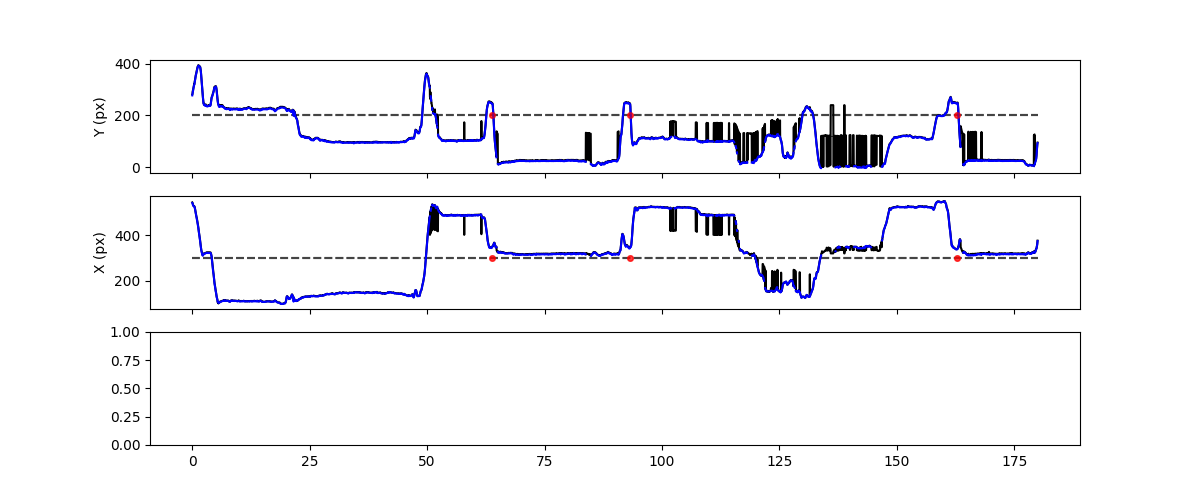

In [10]:
debug_twindow = (0, 180)

fig, axs = plt.subplots(3,1, sharex=True, **{'figsize':(12, 5)})

vplot.plot_session_trajectory(
    mat, 
    fps=fps, 
    center=(300,200), 
    trial_times=trials['starttime_video'].to_numpy(),
    time_window = debug_twindow,
    axs = axs)

vplot.plot_session_trajectory(
    dlc, 
    fps=fps, 
    center=(300,200), 
    trial_times=trials['starttime_video'].to_numpy(),
    time_window = debug_twindow,
    axs = axs,
    color = 'b')

plt.show()

vplot.plot_session_trajectory(
    original, 
    fps=fps, 
    center=(300,200), 
    trial_times=trials['starttime_video'].to_numpy(),
    time_window = debug_twindow)

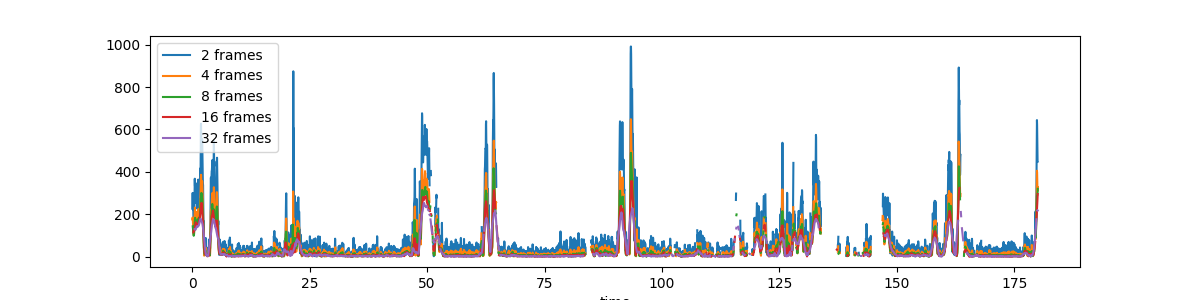

In [12]:
dlc_speed = vtran.compute_speed(df=dlc.copy().reset_index(names='frame'), window=8, fps=fps)

dlc_speed = dlc_speed[(dlc_speed['time'] >= debug_twindow[0]) & (dlc_speed['time'] < debug_twindow[1])]
dlc_speed.plot(x='time',y='speed', ax=axs[2], legend=False)

axs[2].set_ylabel('Speed (pix/s)')
plt.show()

In [14]:
dlc_tt = dlc.copy().reset_index(names='frame')

xy_mat = vtran.get_trial_trajectories(dlc_tt, fps=fps, ev_times=trials['starttime_video'].to_numpy(), window=(-4.1, 2.2) )


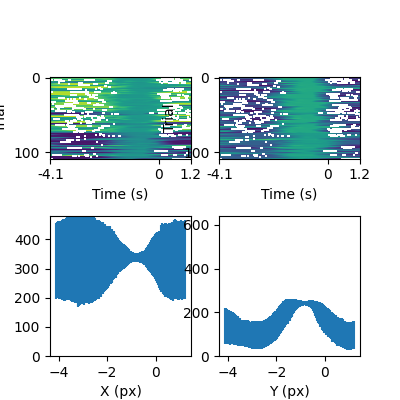

In [15]:
tt_plot = vplot.trial_trajectory_plot(
    data=xy_mat,
    im_size=(640, 480),
    time_window=(-4.1, 1.2),
    fig_size = (4, 4)
    )

tt_plot.draw_heatmap()
tt_plot.draw_mean()

In [ ]:
a = np.mean(xy_mat, axis=0)
a.shape
# vplot.plot_trial_trajectory(xy_mat, time_window=(-4.1, 1.2), im_size=(640, 480))

In [ ]:
# Plot tracking data around the time of trial onset
trials['start_frame'] = np.round(trials.starttime_video * fps) - fps
trials['response_frame'] = trials.starttime_video + (2*np.round(fps))


vplot.plot_trial_trajectory( df=dlc_speed[['frame','head_x','head_y','speed']], trials=trials, im_size=(640, 480), fps=fps)

## Appendix

Some choices need to be made about hyper-parameters such as the window over which we estimate head speed. The code below shows the exploration of different values to illustrate the motivation for specific choices.

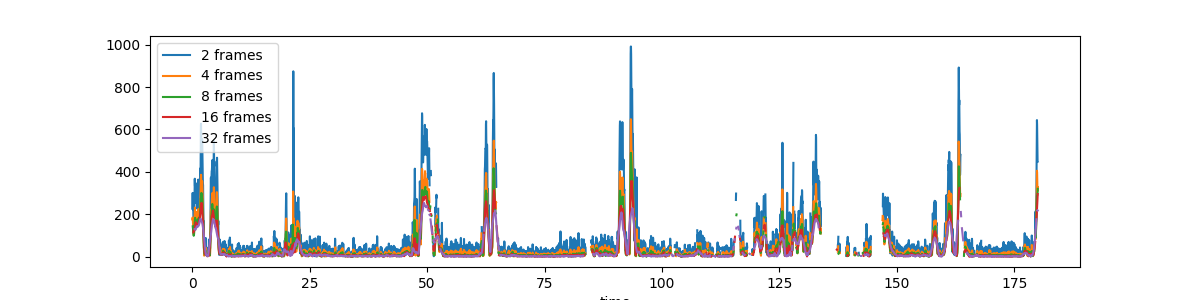

In [11]:
# Check speed calculation
fig, ax = plt.subplots(1,1, sharex=True, **{'figsize':(12, 3)})

# Look at windows increasing in powers of 2 (e.g. 2, 4, 8... samples)
for window_size_exp in range(1, 6):

    dlc_speed = vtran.compute_speed(df=dlc.copy().reset_index(names='frame'), window=2**window_size_exp, fps=fps)
    dlc_speed = dlc_speed[(dlc_speed['time'] >= debug_twindow[0]) & (dlc_speed['time'] < debug_twindow[1])]

    col_name = f"{2**window_size_exp} frames"
    dlc_speed = dlc_speed.rename({'speed':col_name}, axis=1)

    dlc_speed.plot(x='time',y=col_name, ax=ax)

plt.show()

One thing that's immediately obvious from the first few rows is how confident DLC is, compared to the matlab results (though we haven't invested heavily in those likelihoods metrics). If we look at the histograms, there is a very nice division of frames from the dlc result, showing either high or low likelihood. We do get something approaching this with the blue LED, but the red LED isn't so clear cut.

(Note, the same issue is present if looking at the peak LED values for Matlab data rather than "likelihoods" )

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True)

dlc.blue_LEDlikelihood.hist(bins=np.arange(0, 1.1, 0.05), ax=axs[0,0])
dlc.red_LEDlikelihood.hist(bins=np.arange(0, 1.1, 0.05), ax=axs[0,1], **{'color':'red'})

mat.blue_LEDlikelihood.hist(bins=20, ax=axs[1,0])
mat.red_LEDlikelihood.hist(bins=20, ax=axs[1,1], **{'color':'red'})


axs[0,0].set_ylabel('Frames (n)')
axs[1,0].set_xlabel('Blue Likelihood')

axs[1,1].set_xlabel('Red Likelihood')
plt.show()

In [ ]:

p_dlc_red = sum(dlc.red_LEDlikelihood > dlc_threshold) / dlc.shape[0]
p_dlc_blue = sum(dlc.blue_LEDlikelihood > dlc_threshold) / dlc.shape[0]
p_dlc_joint = sum((dlc.blue_LEDlikelihood > dlc_threshold) & (dlc.red_LEDlikelihood > dlc_threshold)) / dlc.shape[0]

p_mat_red = sum(mat.red_LEDlikelihood > mat_threshold) / mat.shape[0]
p_mat_blue = sum(mat.blue_LEDlikelihood > mat_threshold) / mat.shape[0]
p_mat_joint = sum((mat.blue_LEDlikelihood > mat_threshold) & (mat.red_LEDlikelihood > mat_threshold)) / mat.shape[0]

print('Proportion of data passing threshold:')
print('\tDeepLabCut:')
print(f"\t\tBlue_LED: {p_dlc_blue:.3f}, Red LED: {p_dlc_red:.3f}")
print(f"\t\tBoth LEDs: {p_dlc_joint:.3f}")

print('\tMatlab tracking:')
print(f"\t\tBlue_LED: {p_mat_blue:.3f}, Red LED: {p_mat_red:.3f}")
print(f"\t\tBoth LEDs: {p_mat_joint:.3f}")